## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-01 22:41:39--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  3.83MB/s    in 1.5s    

2025-03-01 22:41:41 (3.83 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/movies.dat        
replace ml-1m/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ml-1m/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ml-1m/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y a
  inflating: ml-1m/ratings.dat       
replace ml-1m/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inf

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [9]:
n_items = len(df_train.item_id.unique())
n_users = len(df_train.user_id.unique())

In [10]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    # Закодируем user_id и item_id в последовательные индексы
    global n_items, n_users

    result = np.zeros((n_users, n_items))
    # Заполняем матрицу значениями рейтингов
    for _, row in df.iterrows():
        result[row['user_id'], row['item_id']] = row['rating']

    return result

In [11]:
interactions = df_to_matrix(df_train)

In [12]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    dense_matrix = df_to_matrix(df)
    coo_matrix = coo_array(dense_matrix)
    return coo_matrix

In [13]:
coo_interactions = df_to_coo(df_train)

In [14]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [15]:
from scipy.sparse.linalg import svds
from numpy.linalg import svd as full_svd
from scipy.sparse import coo_array, issparse

In [16]:
def make_svd(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # Проверяем, является ли матрица разреженной
    is_sparse = issparse(interactions)
    if is_sparse:
        # Для разреженной матрицы используем scipy.sparse.linalg.svds
        if n_singular_values == -1:
            n_singular_values = min(interactions.shape) - 1
        U, S, Vt = svds(interactions, k=n_singular_values)

        U = U[:, ::-1]
        S = S[::-1]
        Vt = Vt[::-1, :]

    else:
        # Для плотной матрицы используем numpy.linalg.svd
        U, S, Vt = full_svd(interactions, full_matrices=True)

        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            Vt = Vt[:n_singular_values, :]
    # Создаем прямоугольную диагональную матрицу S
    S_matrix = np.zeros((U.shape[1], Vt.shape[0]))
    min_dim = min(S_matrix.shape)
    S_matrix[:min_dim, :min_dim] = np.diag(S)

    return U, S_matrix, Vt

In [17]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [18]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [19]:
def make_svd_recommendations(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    # Выполняем SVD
    U, S, V = make_svd(interactions, n_singular_values)

    # Восстанавливаем матрицу
    reconstructed_matrix = U @ S @ V

    # Исключаем айтемы, с которыми пользователь уже взаимодействовал
    if issparse(interactions):
        interactions = interactions.toarray()  # Преобразуем разреженную матрицу в плотную

    # Маска для исключения уже взаимодействовавших айтемов
    mask = (interactions == 0)

    # Применяем маску к восстановленной матрице
    masked_matrix = np.where(mask, reconstructed_matrix, -np.inf)

    # Находим топ-k айтемов для каждого пользователя
    recommendations = np.argsort(-masked_matrix, axis=1)[:, :top_k]


    return recommendations #shape ~ [n_users, top_k]

In [20]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [21]:
from sklearn.metrics import ndcg_score

In [22]:
def calculate_ndcg(test_matrix, recommendations, k=100):
    ndcg_scores = []
    n_items_test = test_matrix.shape[1]  # Количество айтемов в тестовой матрице

    for user_idx in range(test_matrix.shape[0]):
        true_scores = test_matrix[user_idx]  # Реальные взаимодействия пользователя
        pred_scores = np.zeros(n_items_test)  # Инициализируем нулями

        # Фильтруем рекомендации: оставляем только те, которые есть в тестовой матрице
        valid_recommendations = [item_idx for item_idx in recommendations[user_idx] if item_idx < n_items_test]

        # Устанавливаем 1 для рекомендованных айтемов
        pred_scores[valid_recommendations] = 1

        # Вычисляем NDCG
        if np.any(true_scores):  # Проверяем, есть ли реальные взаимодействия
            ndcg_scores.append(ndcg_score([true_scores], [pred_scores], k=k))

    # Возвращаем среднее значение NDCG
    return np.mean(ndcg_scores) if ndcg_scores else 0.0

In [23]:
test_interactions = df_to_matrix(df_test)
test_coo = df_to_coo(df_test)

In [24]:
import time
from matplotlib import pyplot as plt

In [25]:
n_singular_values_list = [2, 10, 50, 250, 1250]
def plot_graphs(interactions: Union[np.ndarray, coo_array], top_k: int = 100):
    ndcg_scores = []
    times = []
    for n_singular_values in n_singular_values_list:
        start_time = time.time()
        recommendations = make_svd_recommendations(interactions, n_singular_values, top_k)
        ndcg = calculate_ndcg(test_interactions, recommendations, k=top_k)

        elapsed_time = time.time() - start_time

        ndcg_scores.append(ndcg)
        times.append(elapsed_time)

        print(f"n_singular_values={n_singular_values}, NDCG={ndcg:.4f}, Time={elapsed_time:.2f} с")

    plt.figure(figsize=(12, 5))

    # График NDCG
    plt.subplot(1, 2, 1)
    plt.plot(n_singular_values_list, ndcg_scores, marker='o')
    plt.xlabel("n_singular_values")
    plt.ylabel("NDCG")
    plt.xscale('log')
    plt.title("Зависимость NDCG от n_singular_values")

    # График времени
    plt.subplot(1, 2, 2)
    plt.plot(n_singular_values_list, times, marker='o', color='orange')
    plt.xlabel("n_singular_values")
    plt.ylabel("Time (sec)")
    plt.xscale('log')
    plt.title("Зависимость времени работы от n_singular_values")

    plt.tight_layout()
    plt.show()

n_singular_values=2, NDCG=0.2088, Time=3.10 с
n_singular_values=10, NDCG=0.2257, Time=3.65 с
n_singular_values=50, NDCG=0.2062, Time=5.48 с
n_singular_values=250, NDCG=0.1462, Time=18.64 с
n_singular_values=1250, NDCG=0.0389, Time=193.59 с


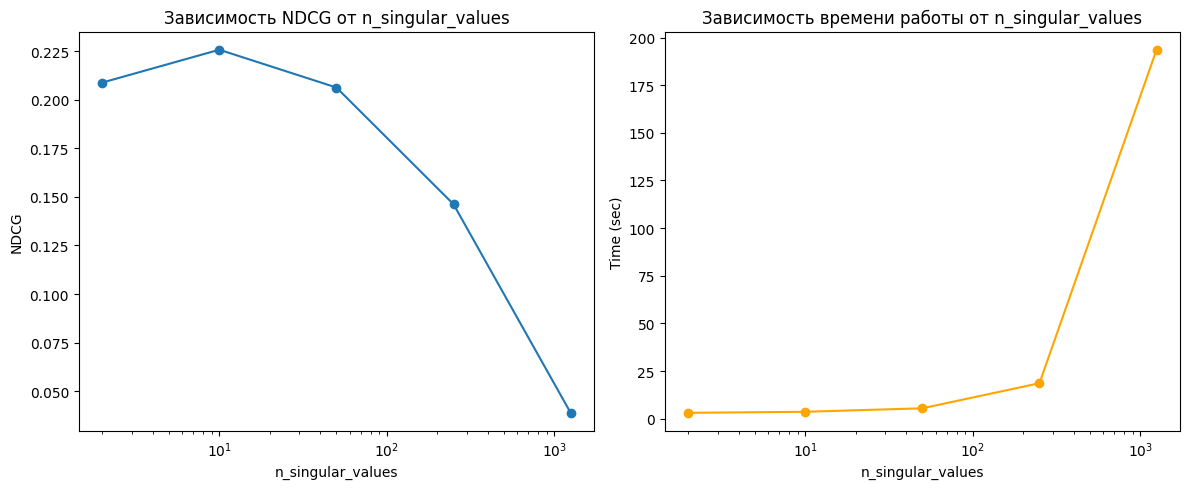

In [26]:
plot_graphs(coo_interactions)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [27]:
from scipy.sparse import coo_array, csr_matrix
from implicit.als import AlternatingLeastSquares

In [28]:
def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    if isinstance(interactions, np.ndarray):
        interactions = csr_matrix(interactions)
    elif isinstance(interactions, coo_array):
        interactions = interactions.tocsr()

    model = AlternatingLeastSquares(
        factors=n_factors,
        alpha=alpha,
        regularization=regularization,
        random_state=42
    )

    model.fit(interactions)

    # Получение рекомендаций
    recommendations = []
    for user_idx in range(interactions.shape[0]):
        ids, _ = model.recommend(user_idx, interactions[user_idx], N=top_k)
        recommendations.append(ids)

    return np.array(recommendations) #shape ~ [n_users, top_k]

In [29]:
recs = make_als_recommendations(interactions, n_factors=10, alpha=5, regularization=0.1)
assert recs.shape == (interactions.shape[0], 100)

/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [30]:
calculate_ndcg(test_interactions, recs, k=100)

0.22006609833347798

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [31]:
movies = pd.read_csv("ml-1m/movies.dat", sep="::", engine='python', encoding='latin-1', header=None, names=['movie_id', 'title', 'genres'])
movies['item_id'] = item_le.fit_transform(movies['movie_id'])
movies.head(5)

,movie_id,title,genres,item_id
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [32]:
movies.iloc[904]

,904
movie_id,916
title,Roman Holiday (1953)
genres,Comedy|Romance
item_id,904


In [33]:
import random

In [34]:
interactions_csr = csr_matrix(interactions)

als = AlternatingLeastSquares(
    factors=100,
    alpha=1,
    regularization=0.1,
    random_state=42
)
als.fit(interactions_csr)

  0%|          | 0/15 [00:00<?, ?it/s]

In [35]:
def explain_recommendations(model, user_idx, item_idx, movies):

    # Получаем объяснение
    explanation = model.explain(user_idx, interactions_csr, item_idx, N=4)

    # Название фильма
    movie_title = movies[movies['item_id'] == item_idx]['title'].values[0]

    # Формируем объяснение
    result = f"Рекомендация для пользователя {user_idx}:\n"
    result += f"Фильм: {movie_title}\n"
    total_score = explanation[0]
    result += f"Общий скор: {total_score:.4f}\n"
    result += '\n'
    # Вклад факторов
    result += "Вклад факторов:\n"
    for item_id, score in explanation[1]:
        item_title = movies[movies['item_id'] == item_id]['title'].values[0]
        item_genres = movies[movies['item_id'] == item_id]['genres'].values[0]
        result += f"Фильм {item_title} ({item_genres}): {score:.4f}\n"
    result += '='*100
    return result

item_idx = 904  # Индекс фильма
users = random.sample(sorted(df_train.user_id.unique()), 5)
for user_idx in users:
  print(explain_recommendations(als, user_idx, item_idx, movies))

Рекомендация для пользователя 2210:
Фильм: Roman Holiday (1953)
Общий скор: 0.6097

Вклад факторов:
Фильм Liebelei (1933) (Romance): 0.0918
Фильм Singin' in the Rain (1952) (Musical|Romance): 0.0471
Фильм Hands on a Hard Body (1996) (Documentary): 0.0454
Фильм Down in the Delta (1998) (Drama): 0.0405
Рекомендация для пользователя 5144:
Фильм: Roman Holiday (1953)
Общий скор: 0.3921

Вклад факторов:
Фильм Like Water for Chocolate (Como agua para chocolate) (1992) (Drama|Romance): 0.0728
Фильм Philadelphia Story, The (1940) (Comedy|Romance): 0.0649
Фильм Bogus (1996) (Children's|Drama|Fantasy): 0.0571
Фильм Singin' in the Rain (1952) (Musical|Romance): 0.0537
Рекомендация для пользователя 2647:
Фильм: Roman Holiday (1953)
Общий скор: 0.5797

Вклад факторов:
Фильм Roman Holiday (1953) (Comedy|Romance): 0.2796
Фильм Wizard of Oz, The (1939) (Adventure|Children's|Drama|Musical): 0.0802
Фильм Bogus (1996) (Children's|Drama|Fantasy): 0.0629
Фильм Like Water for Chocolate (Como agua para choco

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [36]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.metrics import ndcg_score

# Загрузка данных (предположим, что df_train и df_test уже загружены)
# df_train содержит колонки: user_id, item_id, rating, datetime
# df_test содержит колонки: user_id, item_id, rating

# Вариант 1: Бинаризация всех рейтингов
def binarize_all_ratings(df):
    df_binary = df.copy()
    df_binary['rating'] = 1
    return df_binary

# Вариант 2: Бинаризация рейтингов 4 и 5
def binarize_high_ratings(df):
    df_binary = df.copy()
    df_binary['rating'] = df_binary['rating'].apply(lambda x: 1 if x >= 4 else 0)
    return df_binary

# Вариант 3: Бинаризация рейтингов 4 и 5 с отрицательными значениями
def binarize_high_ratings_negative(df):
    df_binary = df.copy()
    df_binary['rating'] = df_binary['rating'].apply(lambda x: 1 if x >= 4 else -1)
    return df_binary

# Вариант 4: Бинаризация рейтингов 4 и 5 с учётом времени
def binarize_high_ratings_time_decay(df):
    df_binary = df.copy()
    max_date = df_binary['datetime'].max()
    df_binary['days_diff'] = (max_date - df_binary['datetime']).dt.days
    df_binary['rating'] = df_binary.apply(lambda row: 1 if row['rating'] >= 4 else -1, axis=1)
    df_binary['rating'] *= np.exp(-0.01 * df_binary['days_diff'])  # Экспоненциальное сглаживание
    return df_binary

# Вариант 5: Собственный вариант (например, логарифмическое сглаживание)
def custom_transformation(df):
    df_custom = df.copy()
    df_custom['rating'] = np.log1p(df_custom['rating'])  # Логарифмическое преобразование
    return df_custom

# Применяем преобразования
df_train_binary_all = binarize_all_ratings(df_train)
df_train_binary_high = binarize_high_ratings(df_train)
df_train_binary_high_neg = binarize_high_ratings_negative(df_train)
df_train_binary_time_decay = binarize_high_ratings_time_decay(df_train)
df_train_custom = custom_transformation(df_train)

In [37]:
def df_to_csr(df):
    rows = df['user_id'].values
    cols = df['item_id'].values
    data = df['rating'].values
    return csr_matrix((data, (rows, cols)), shape=(df['user_id'].max() + 1, df['item_id'].max() + 1))\

train_csr_all = df_to_csr(df_train_binary_all).astype(np.float32)
train_csr_high = df_to_csr(df_train_binary_high).astype(np.float32)
train_csr_high_neg = df_to_csr(df_train_binary_high_neg).astype(np.float32)
train_csr_time_decay = df_to_csr(df_train_binary_time_decay).astype(np.float32)
train_csr_custom = df_to_csr(df_train_custom).astype(np.float32)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Binary All: iALS NDCG=0.1808, SVD NDCG=0.2126
Binary High: iALS NDCG=0.1883, SVD NDCG=0.2032
Binary High Negative: iALS NDCG=0.1911, SVD NDCG=0.2154
Binary High Time Decay: iALS NDCG=0.1880, SVD NDCG=0.2175
Custom: iALS NDCG=0.1859, SVD NDCG=0.2215


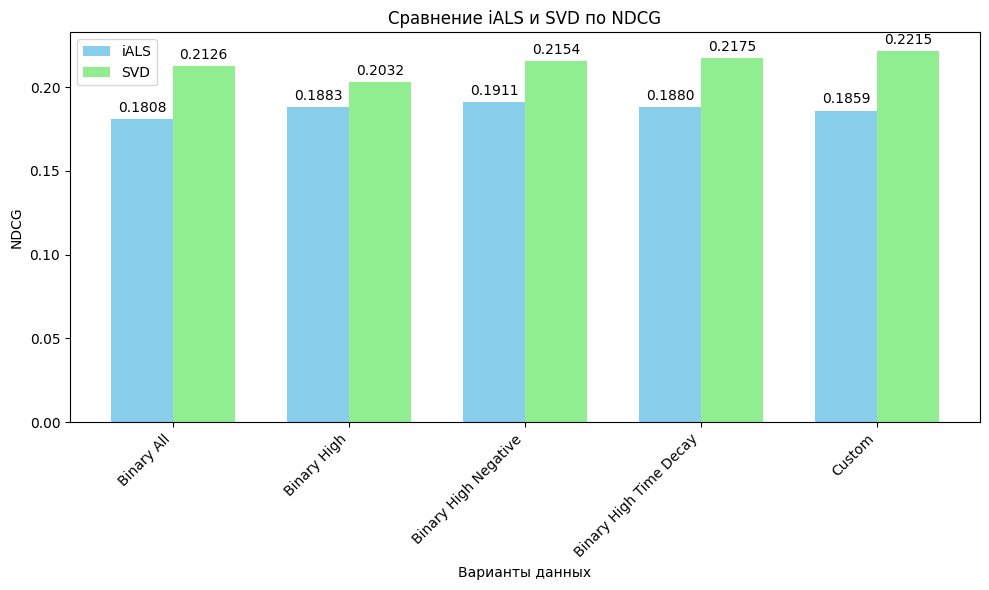

In [38]:
def train_and_evaluate(train_csr, df_test):
    # Преобразуем тестовую выборку в CSR-матрицу
    test_csr = df_to_csr(df_test)

    recs_als = make_als_recommendations(train_csr)

    recs_svd = make_svd_recommendations(train_csr, n_singular_values=10)
    # Оценка iALS
    ndcg_als = calculate_ndcg(test_interactions, recs_als, k=100)

    # Оценка SVD
    ndcg_svd = calculate_ndcg(test_interactions, recs_svd, k=100)

    return ndcg_als, ndcg_svd

# Оценка для каждого варианта данных
results = {
    "Binary All": train_and_evaluate(train_csr_all, df_test),
    "Binary High": train_and_evaluate(train_csr_high, df_test),
    "Binary High Negative": train_and_evaluate(train_csr_high_neg, df_test),
    "Binary High Time Decay": train_and_evaluate(train_csr_time_decay, df_test),
    "Custom": train_and_evaluate(train_csr_custom, df_test),
}

# Вывод результатов
for name, (ndcg_als, ndcg_svd) in results.items():
    print(f"{name}: iALS NDCG={ndcg_als:.4f}, SVD NDCG={ndcg_svd:.4f}")

# Подготовка данных для графика
labels = list(results.keys())
ials_scores = [score[0] for score in results.values()]
svd_scores = [score[1] for score in results.values()]

# Позиции для столбцов
x = np.arange(len(labels))

# Ширина столбцов
width = 0.35

# Построение графика
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, ials_scores, width, label='iALS', color='skyblue')
rects2 = ax.bar(x + width/2, svd_scores, width, label='SVD', color='lightgreen')

# Добавление подписей
ax.set_xlabel('Варианты данных')
ax.set_ylabel('NDCG')
ax.set_title('Сравнение iALS и SVD по NDCG')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

# Добавление значений на столбцы
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Смещение текста
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Настройка внешнего вида
fig.tight_layout()

# Показать график
plt.show()

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [39]:
from tqdm import tqdm

In [40]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):
        R = csr_matrix(interactions)
        num_users, num_items = R.shape
        epsilon = 1e-8  # Маленькое число для стабилизации логарифма

        # Инициализация факторов пользователей и предметов
        self.user_factors = np.random.randn(num_users, self.n_factors)
        self.item_factors = np.random.randn(num_items, self.n_factors)

        for iteration in range(n_iterations):
            print(f"Iteration {iteration + 1}/{n_iterations}")

            # Предварительное вычисление Y^T Y
            YTY = self.item_factors.T @ self.item_factors

            # Обновление факторов пользователей
            for u in tqdm(range(num_users)):
                items_u = R[u].nonzero()[1]  # Получаем предметы, с которыми взаимодействовал пользователь u
                if len(items_u) == 0:
                    continue

                # Логарифмическое масштабирование для уверенности
                c_ui = 1 + self.alpha * np.log(1 + R[u, items_u].toarray() / epsilon)
                C_u = np.eye(len(items_u)) * c_ui

                p_u = np.ones(len(items_u))
                YTCuY = YTY + self.item_factors[items_u].T @ (C_u - np.eye(len(items_u))) @ self.item_factors[items_u]
                YTCup = self.item_factors[items_u].T @ (C_u @ p_u)
                self.user_factors[u] = np.linalg.inv(YTCuY + self.reg_coef * np.eye(self.n_factors)) @ YTCup

            # Предварительное вычисление X^T X
            XTX = self.user_factors.T @ self.user_factors

            # Обновление факторов предметов
            for i in tqdm(range(num_items)):
                users_i = R[:, i].nonzero()[0]  # Получаем пользователей, которые взаимодействовали с предметом i
                if len(users_i) == 0:
                    continue

                # Логарифмическое масштабирование для уверенности
                c_ui = 1 + self.alpha * np.log(1 + R[users_i, i].toarray() / epsilon)
                C_i = np.eye(len(users_i)) * c_ui

                p_i = np.ones(len(users_i))
                XTCiX = XTX + self.user_factors[users_i].T @ (C_i - np.eye(len(users_i))) @ self.user_factors[users_i]
                XTCip = self.user_factors[users_i].T @ (C_i @ p_i)
                self.item_factors[i] = np.linalg.inv(XTCiX + self.reg_coef * np.eye(self.n_factors)) @ XTCip
    def predict(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы с которыми юзер взаимодействовал не должны попасть в рекомендации)
        if self.user_factors is None or self.item_factors is None:
            raise ValueError("Model is not fitted yet. Call fit() first.")

        num_users = self.user_factors.shape[0]
        predicts = np.zeros((num_users, top_k), dtype=int)

        for u in range(num_users):
            # Вычисляем предсказанные оценки для всех предметов
            scores = self.user_factors[u] @ self.item_factors.T

            # Исключаем предметы, с которыми пользователь уже взаимодействовал
            interacted_items = np.where(self.user_factors[u] != 0)[0]
            scores[interacted_items] = -np.inf  # Исключаем их из рекомендаций

            top_items = np.argsort(scores)[-top_k:][::-1]
            predicts[u] = top_items

        return predicts # shape ~ [n_users, top_k]

In [41]:
model = iALS(n_factors=5, alpha=1.0, reg_coef=1)
model.fit(interactions, n_iterations=5)

Iteration 1/5


100%|██████████| 3010/3010 [00:19<00:00, 151.07it/s]


Iteration 2/5


100%|██████████| 3010/3010 [00:19<00:00, 151.80it/s]


Iteration 3/5


100%|██████████| 3010/3010 [00:19<00:00, 151.74it/s]


Iteration 4/5


100%|██████████| 3010/3010 [00:20<00:00, 149.86it/s]


Iteration 5/5


100%|██████████| 3010/3010 [00:19<00:00, 151.60it/s]


In [42]:
ndcg_als = calculate_ndcg(test_interactions, model.predict(), k=100)
print(ndcg_als)

0.13815322363854401
